In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [2]:
# Cargo el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]
data = pd.read_csv(url, names=column_names)

In [3]:
# Convierto las columnas categóricas a tipo 'category'
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
for column in categorical_columns:
    data[column] = data[column].astype('category')

In [4]:
# Convertir 'income' a binario
data['income_binary'] = data['income'].cat.codes

In [5]:
#Mostramos la información o contenido del dataset
print(data.head())  # Ver las primeras filas del dataset
print(data.info())  # Resumen de los tipos de datos y valores nulos
print(data.describe())  # Estadísticas básicas de las variables numéricas

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  \
0          2174             0              40   United-States   <=5

In [6]:
# Identifico valores perdidos 
missing_values = data.isnull().sum() # Contar valores nulos por columna
print(missing_values)



age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
income_binary     0
dtype: int64


In [7]:
# Verificar valores únicos en cada columna categórica
for col in categorical_columns:
    print(f"{col}: {data[col].nunique()} valores únicos")

# Ver los valores únicos con sus respectivas frecuencias
for col in categorical_columns:
    print(f"\nValores únicos en {col}:")
    print(data[col].value_counts())

workclass: 9 valores únicos
education: 16 valores únicos
marital_status: 7 valores únicos
occupation: 15 valores únicos
relationship: 6 valores únicos
race: 5 valores únicos
sex: 2 valores únicos
native_country: 42 valores únicos
income: 2 valores únicos

Valores únicos en workclass:
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

Valores únicos en education:
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

Valores únicos en marital_

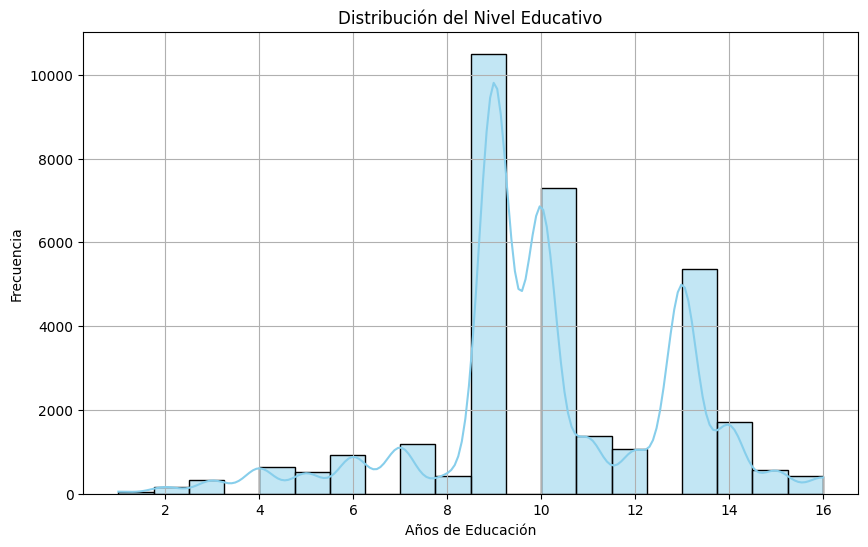

In [8]:
# # Histograma del Nivel Educativo (Matplotlib)

plt.figure(figsize=(10, 6))
sns.histplot(data['education_num'], kde=True, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución del Nivel Educativo')
plt.xlabel('Años de Educación')
plt.ylabel('Frecuencia')
plt.grid(True) 
plt.show()

In [9]:
# Resumen numérico
print("Resumen del Nivel Educativo:")
print(data['education_num'].describe())

Resumen del Nivel Educativo:
count    32561.000000
mean        10.080679
std          2.572720
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education_num, dtype: float64


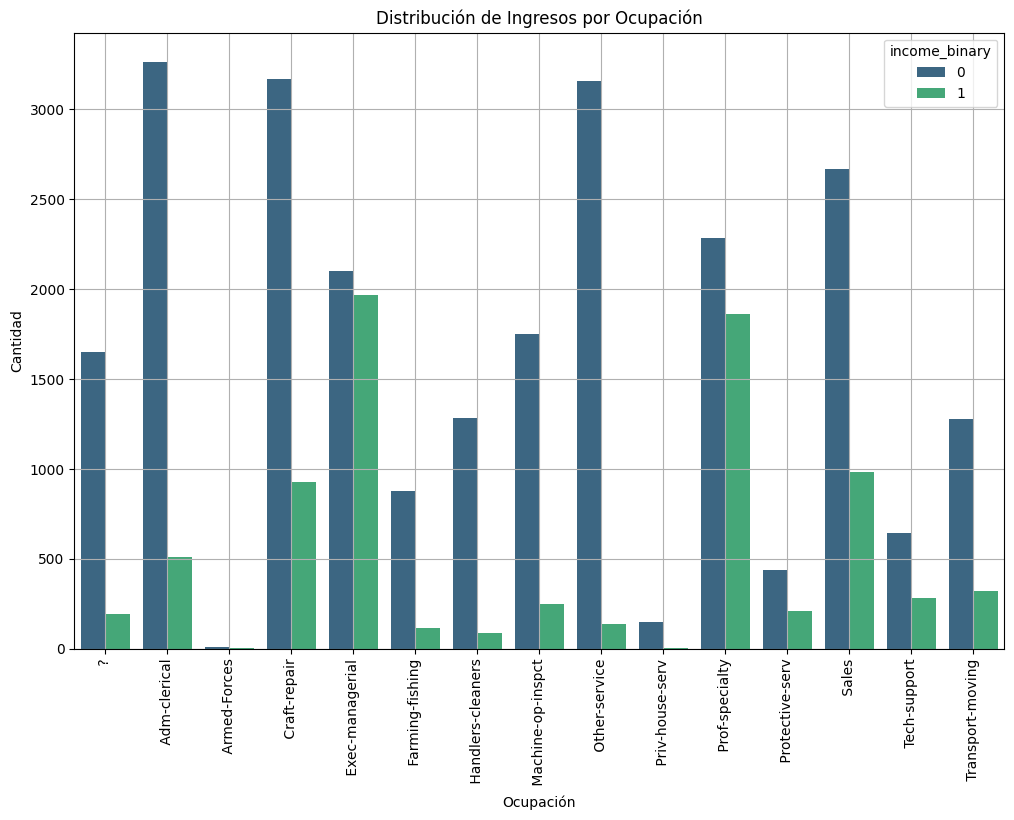

In [10]:
# # Gráfico de Barras de Ingresos por Ocupación (Seaborn)

plt.figure(figsize=(12, 8))
sns.countplot(x='occupation', hue='income_binary', data=data, palette='viridis')
plt.title('Distribución de Ingresos por Ocupación')
plt.xlabel('Ocupación')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

In [11]:
# Resumen numérico de Ingresos por Ocupación
print("Resumen de Ingresos por Ocupación:")
income_summary = data.groupby('occupation')['income_binary'].describe()
print(income_summary)

Resumen de Ingresos por Ocupación:
                    count      mean       std  min  25%  50%  75%  max
occupation                                                            
?                  1843.0  0.103635  0.304870  0.0  0.0  0.0  0.0  1.0
Adm-clerical       3770.0  0.134483  0.341216  0.0  0.0  0.0  0.0  1.0
Armed-Forces          9.0  0.111111  0.333333  0.0  0.0  0.0  0.0  1.0
Craft-repair       4099.0  0.226641  0.418709  0.0  0.0  0.0  0.0  1.0
Exec-managerial    4066.0  0.484014  0.499806  0.0  0.0  0.0  1.0  1.0
Farming-fishing     994.0  0.115694  0.320019  0.0  0.0  0.0  0.0  1.0
Handlers-cleaners  1370.0  0.062774  0.242644  0.0  0.0  0.0  0.0  1.0
Machine-op-inspct  2002.0  0.124875  0.330660  0.0  0.0  0.0  0.0  1.0
Other-service      3295.0  0.041578  0.199653  0.0  0.0  0.0  0.0  1.0
Priv-house-serv     149.0  0.006711  0.081923  0.0  0.0  0.0  0.0  1.0
Prof-specialty     4140.0  0.449034  0.497456  0.0  0.0  0.0  1.0  1.0
Protective-serv     649.0  0.325116  0.468

C:\Users\ari_m\AppData\Local\Temp\ipykernel_31472\778703908.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_summary = data.groupby('occupation')['income_binary'].describe()


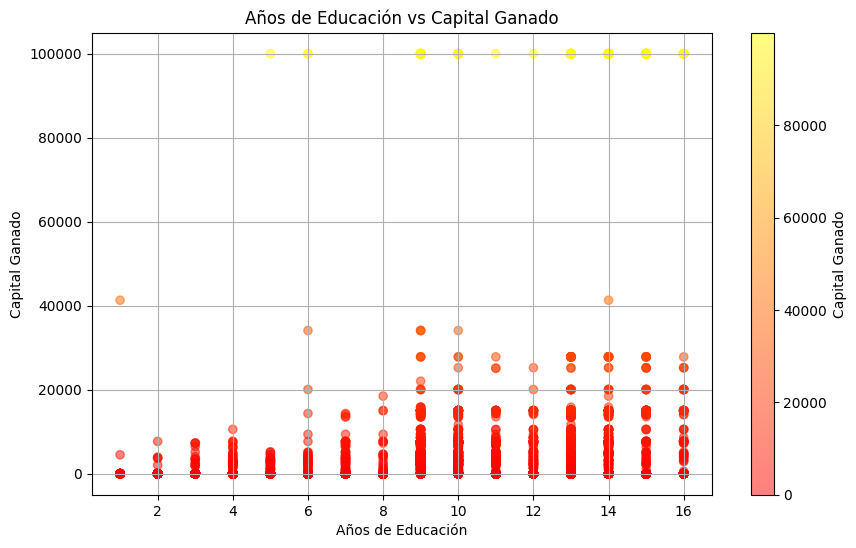

In [12]:
# # Scatterplot: Años de Educación vs Capital Ganado (Matplotlib)
plt.figure(figsize=(10, 6))
plt.scatter(data['education_num'], data['capital_gain'], alpha=0.5, c=data['capital_gain'], cmap='autumn')
plt.title('Años de Educación vs Capital Ganado')
plt.xlabel('Años de Educación')
plt.ylabel('Capital Ganado')
plt.colorbar(label='Capital Ganado') 
plt.grid(True)
plt.show()

In [13]:
# Resumen numérico de Años de Educación y Capital Ganado
print("Resumen de Años de Educación y Capital Ganado:")
education_capital_summary = data[['education_num', 'capital_gain']].describe()
print(education_capital_summary)

# Correlación entre Años de Educación y Capital Ganado
correlation = data['education_num'].corr(data['capital_gain'])
print(f"\nCorrelación entre Años de Educación y Capital Ganado: {correlation:.2f}")

Resumen de Años de Educación y Capital Ganado:
       education_num  capital_gain
count   32561.000000  32561.000000
mean       10.080679   1077.648844
std         2.572720   7385.292085
min         1.000000      0.000000
25%         9.000000      0.000000
50%        10.000000      0.000000
75%        12.000000      0.000000
max        16.000000  99999.000000

Correlación entre Años de Educación y Capital Ganado: 0.12


C:\Users\ari_m\AppData\Local\Temp\ipykernel_31472\33450293.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex', y='hours_per_week', data=data, palette='Set2', showmeans=True)


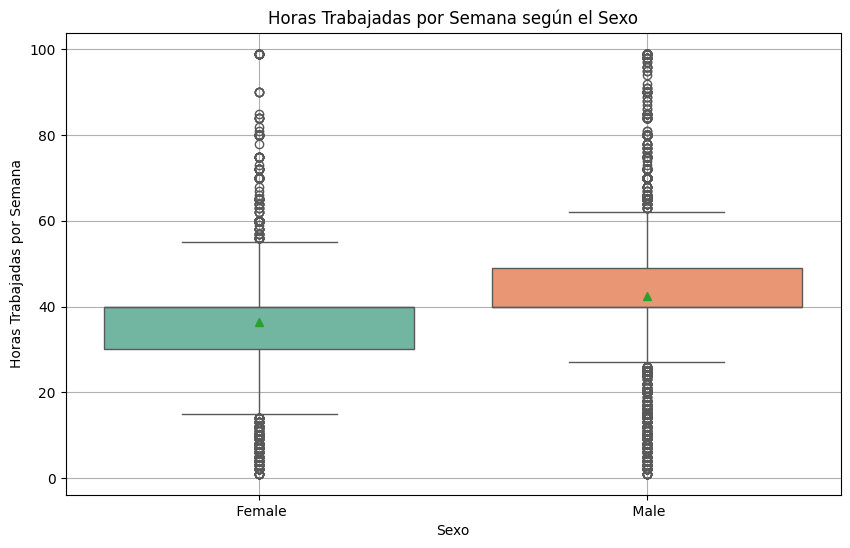

In [14]:
# # Boxplot de Horas Trabajadas por Semana según el Sexo (Seaborn)

plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='hours_per_week', data=data, palette='Set2', showmeans=True)
plt.title('Horas Trabajadas por Semana según el Sexo')
plt.xlabel('Sexo')
plt.ylabel('Horas Trabajadas por Semana')
plt.grid(True)
plt.show()

In [15]:
# Resumen numérico
print("Resumen de Horas Trabajadas por Semana según el Sexo:")
print(data.groupby('sex')['hours_per_week'].describe())

Resumen de Horas Trabajadas por Semana según el Sexo:
          count       mean        std  min   25%   50%   75%   max
sex                                                               
Female  10771.0  36.410361  11.811300  1.0  30.0  40.0  40.0  99.0
Male    21790.0  42.428086  12.119755  1.0  40.0  40.0  49.0  99.0


C:\Users\ari_m\AppData\Local\Temp\ipykernel_31472\2906399191.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('sex')['hours_per_week'].describe())


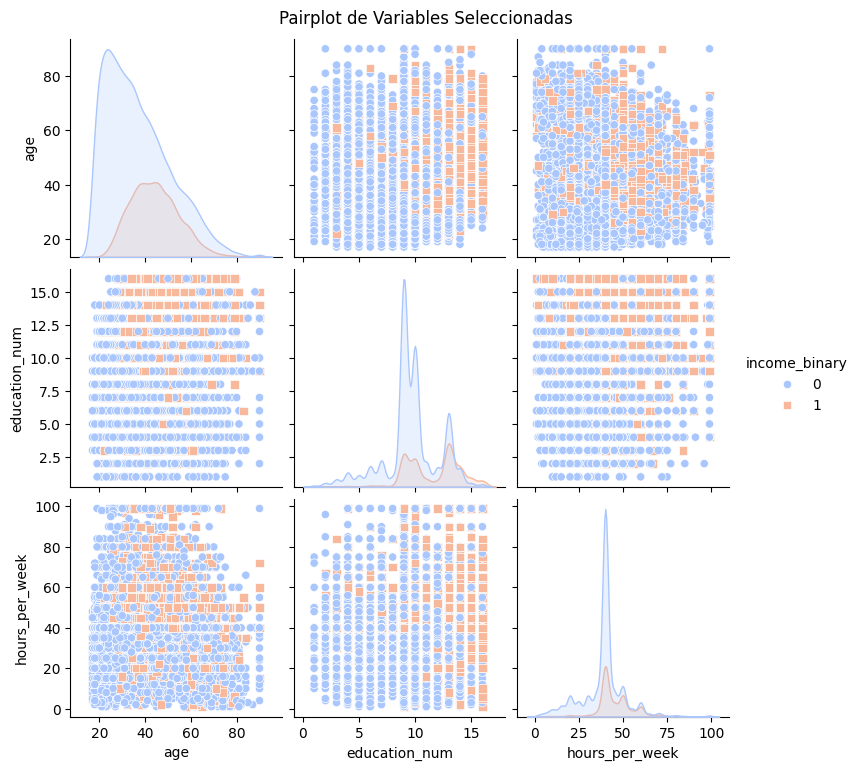

In [16]:
# # Pairplot de Variables Seleccionadas (Seaborn)

sns.pairplot(data[['age', 'education_num', 'hours_per_week', 'income_binary']], hue='income_binary', palette='coolwarm', markers=["o", "s"])
plt.suptitle('Pairplot de Variables Seleccionadas', y=1.02)
plt.show()

In [17]:
# Resumen numérico
print("Resumen de Variables Seleccionadas:")
print(data[['age', 'education_num', 'hours_per_week', 'income_binary']].describe())



Resumen de Variables Seleccionadas:
                age  education_num  hours_per_week  income_binary
count  32561.000000   32561.000000    32561.000000   32561.000000
mean      38.581647      10.080679       40.437456       0.240810
std       13.640433       2.572720       12.347429       0.427581
min       17.000000       1.000000        1.000000       0.000000
25%       28.000000       9.000000       40.000000       0.000000
50%       37.000000      10.000000       40.000000       0.000000
75%       48.000000      12.000000       45.000000       0.000000
max       90.000000      16.000000       99.000000       1.000000


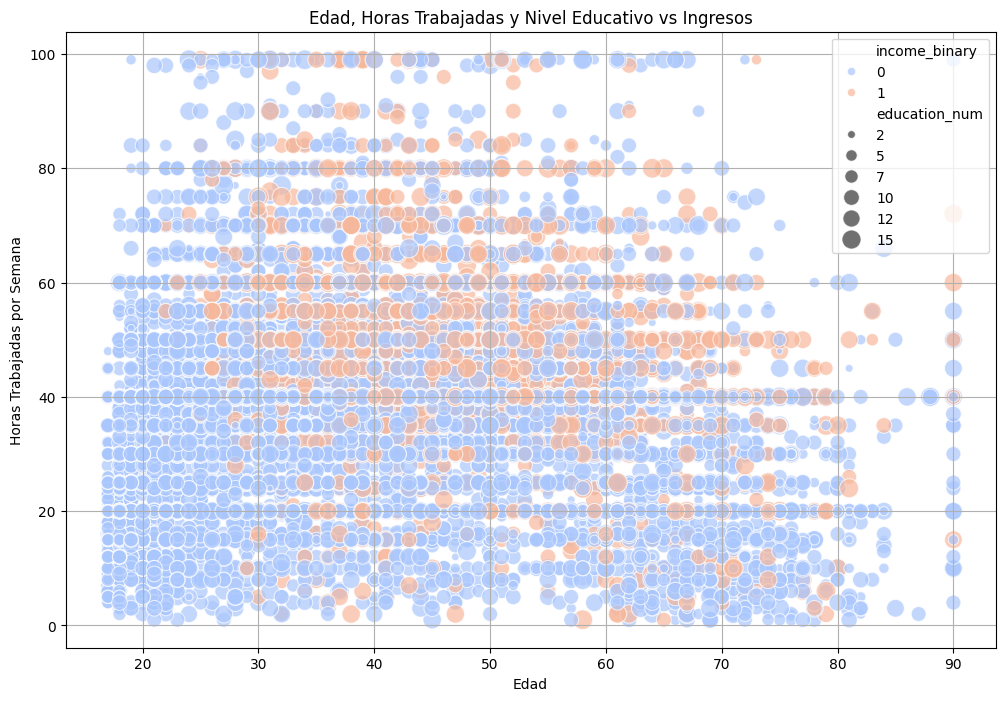

In [18]:
# # Gráfico de Dispersión Multivariado (Seaborn)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='hours_per_week', size='education_num', hue='income_binary', data=data, sizes=(20, 200), palette='coolwarm', alpha=0.7)
plt.title('Edad, Horas Trabajadas y Nivel Educativo vs Ingresos')
plt.xlabel('Edad')
plt.ylabel('Horas Trabajadas por Semana')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [19]:
# Resumen numérico
print("Resumen de Edad, Horas Trabajadas y Nivel Educativo:")
print(data[['age', 'hours_per_week', 'education_num', 'income_binary']].describe())

Resumen de Edad, Horas Trabajadas y Nivel Educativo:
                age  hours_per_week  education_num  income_binary
count  32561.000000    32561.000000   32561.000000   32561.000000
mean      38.581647       40.437456      10.080679       0.240810
std       13.640433       12.347429       2.572720       0.427581
min       17.000000        1.000000       1.000000       0.000000
25%       28.000000       40.000000       9.000000       0.000000
50%       37.000000       40.000000      10.000000       0.000000
75%       48.000000       45.000000      12.000000       0.000000
max       90.000000       99.000000      16.000000       1.000000


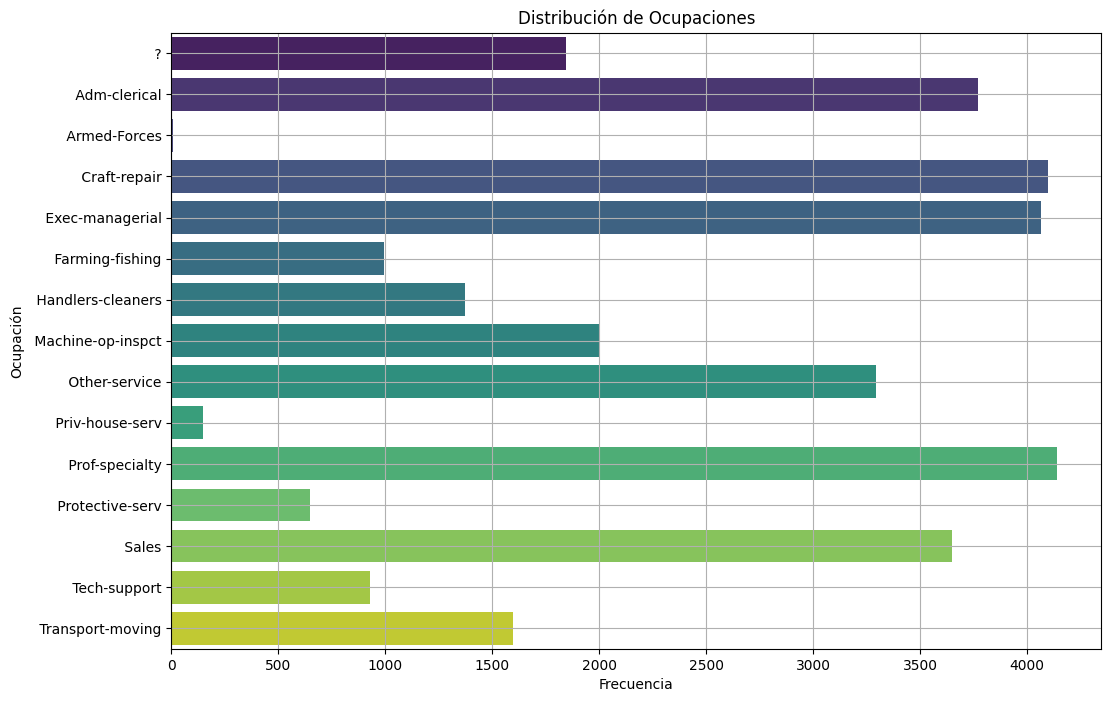

In [20]:
# # Countplot de ocupación (Seaborn)
plt.figure(figsize=(12, 8))
sns.countplot(y='occupation', data=data, hue='occupation', palette='viridis', dodge=False)
plt.title('Distribución de Ocupaciones')
plt.xlabel('Frecuencia')
plt.ylabel('Ocupación')
plt.grid(True)
plt.legend([],[], frameon=False) 
plt.show()

In [21]:
# Resumen numérico
occupation_counts = data['occupation'].value_counts()
print("Resumen de la Distribución de Ocupaciones:")
print(occupation_counts)
print("\nResumen Estadístico:")
print(data['occupation'].describe())

Resumen de la Distribución de Ocupaciones:
occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64

Resumen Estadístico:
count               32561
unique                 15
top        Prof-specialty
freq                 4140
Name: occupation, dtype: object


C:\Users\ari_m\AppData\Local\Temp\ipykernel_31472\3577891887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sex', y='income_binary', data=data, palette='Set2')


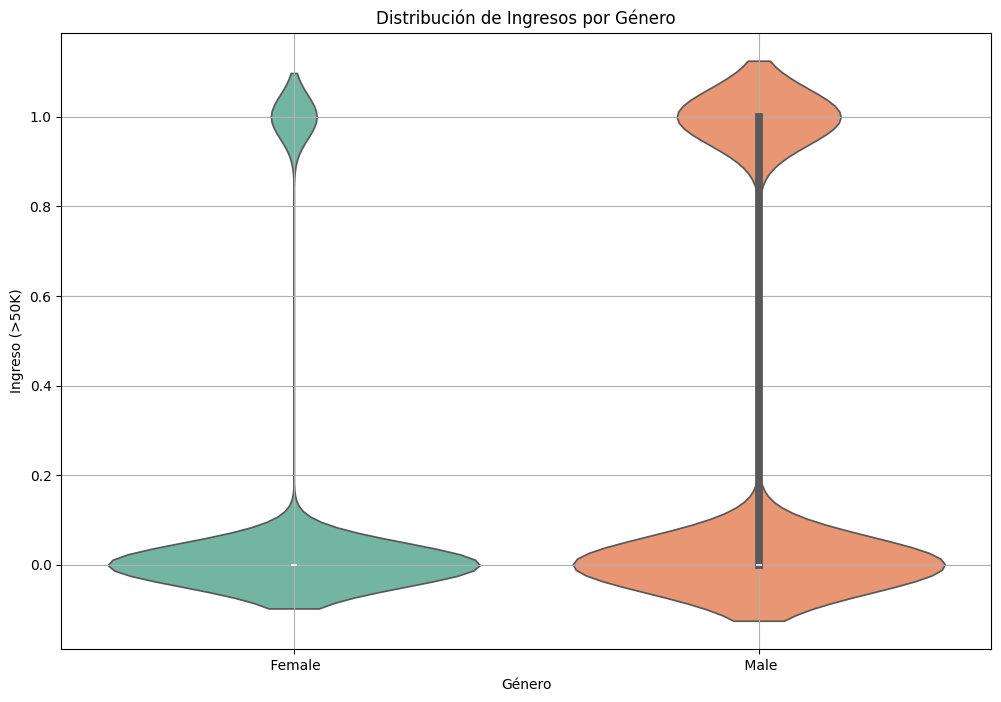

Resumen de Ingresos por Género:
          count      mean       std  min  25%  50%  75%  max
sex                                                         
Female  10771.0  0.109461  0.312231  0.0  0.0  0.0  0.0  1.0
Male    21790.0  0.305737  0.460729  0.0  0.0  0.0  1.0  1.0


C:\Users\ari_m\AppData\Local\Temp\ipykernel_31472\3577891887.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_by_sex = data.groupby('sex')['income_binary'].describe()


In [22]:
# # Gráfico de Violín: Ingresos por Género (Seaborn)

plt.figure(figsize=(12, 8))
sns.violinplot(x='sex', y='income_binary', data=data, palette='Set2')
plt.title('Distribución de Ingresos por Género')
plt.xlabel('Género')
plt.ylabel('Ingreso (>50K)')
plt.grid(True)
plt.show()

# Resumen numérico de Ingresos por Género
income_by_sex = data.groupby('sex')['income_binary'].describe()
print("Resumen de Ingresos por Género:")
print(income_by_sex)

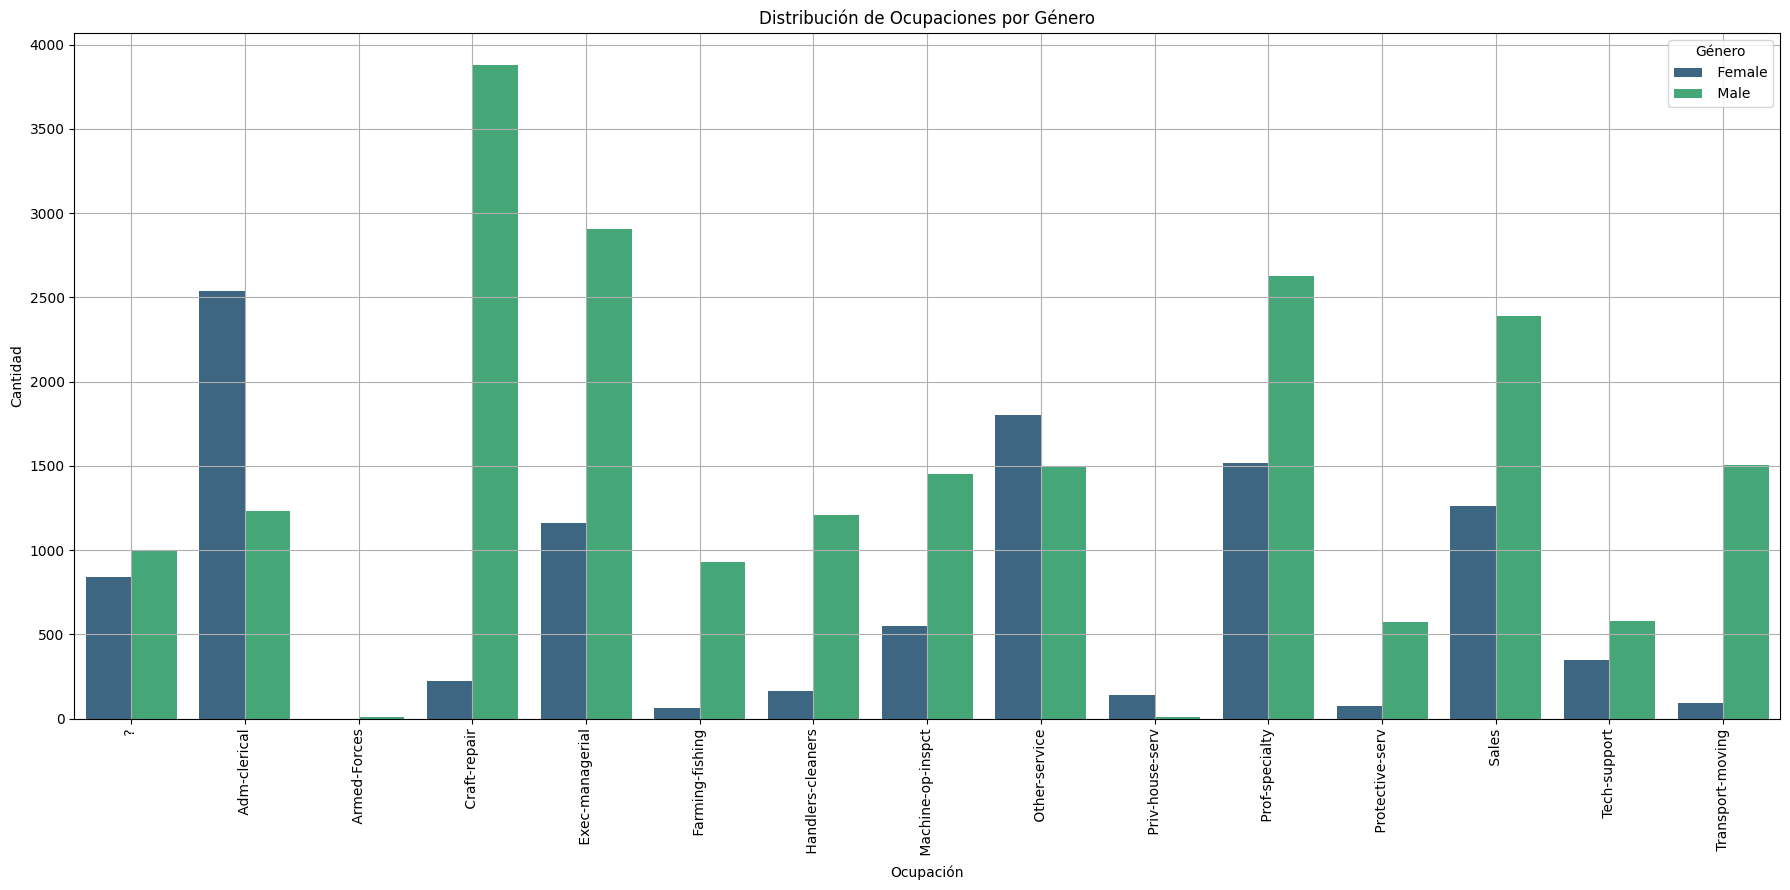

In [23]:
# # Gráfico de Barras Agrupadas: Ocupaciones por Género
plt.figure(figsize=(18, 9))
sns.countplot(x='occupation', hue='sex', data=data, palette='viridis')
plt.title('Distribución de Ocupaciones por Género')
plt.xlabel('Ocupación')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.legend(title='Género')
plt.grid(True)
plt.tight_layout() 
plt.show()

In [24]:
# Resumen numérico por ocupación y género
occupation_gender_counts = data.groupby(['occupation', 'sex']).size().unstack(fill_value=0).describe()

print("Resumen de Ocupaciones por Género:")
print(occupation_gender_counts)

# Resumen numérico de la cantidad de personas por ocupación y género
occupation_gender_counts = data.groupby(['occupation', 'sex']).size().unstack(fill_value=0)
print("Cantidad de Personas por Ocupación y Género:")
print(occupation_gender_counts)

Resumen de Ocupaciones por Género:
sex         Female         Male
count    15.000000    15.000000
mean    718.066667  1452.666667
std     775.554867  1086.856126
min       0.000000     8.000000
25%     115.500000   754.500000
50%     348.000000  1233.000000
75%    1211.000000  1947.000000
max    2537.000000  3877.000000
Cantidad de Personas por Ocupación y Género:
sex                Female  Male
occupation                     
?                     841  1002
Adm-clerical         2537  1233
Armed-Forces            0     9
Craft-repair          222  3877
Exec-managerial      1159  2907
Farming-fishing        65   929
Handlers-cleaners     164  1206
Machine-op-inspct     550  1452
Other-service        1800  1495
Priv-house-serv       141     8
Prof-specialty       1515  2625
Protective-serv        76   573
Sales                1263  2387
Tech-support          348   580
Transport-moving       90  1507


C:\Users\ari_m\AppData\Local\Temp\ipykernel_31472\1896927738.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  occupation_gender_counts = data.groupby(['occupation', 'sex']).size().unstack(fill_value=0).describe()
C:\Users\ari_m\AppData\Local\Temp\ipykernel_31472\1896927738.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  occupation_gender_counts = data.groupby(['occupation', 'sex']).size().unstack(fill_value=0)


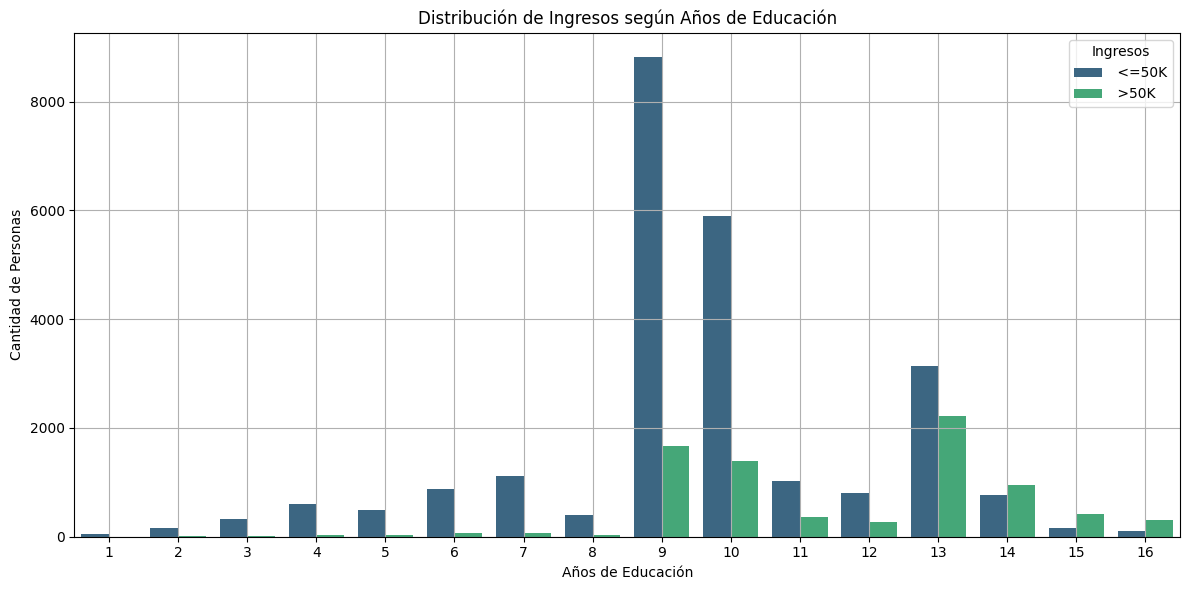

Resumen numérico: Porcentaje de Ingresos >50K según Años de Educación
income_binary       <=50K       >50K
education_num                       
1              100.000000   0.000000
2               96.428571   3.571429
3               95.195195   4.804805
4               93.808050   6.191950
5               94.747082   5.252918
6               93.354770   6.645230
7               94.893617   5.106383
8               92.378753   7.621247
9               84.049138  15.950862
10              80.976546  19.023454
11              73.878437  26.121563
12              75.164011  24.835989
13              58.524743  41.475257
14              44.341265  55.658735
15              26.562500  73.437500
16              25.907990  74.092010


In [25]:
# Convertir la columna de ingresos a binaria: 1 si >50K, 0 si <=50K
data['income_binary'] = data['income'].apply(lambda x: ' >50K' if x == ' >50K' else ' <=50K')

# Gráfico de Barras Agrupadas: Distribución de Ingresos según Años de Educación
plt.figure(figsize=(12, 6))
sns.countplot(x='education_num', hue='income_binary', data=data, palette='viridis')
plt.title('Distribución de Ingresos según Años de Educación')
plt.xlabel('Años de Educación')
plt.ylabel('Cantidad de Personas')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Ingresos')
plt.show()

# Resumen numérico: Porcentaje de Ingresos >50K según Años de Educación
education_income_percentage = data.groupby('education_num')['income_binary'].value_counts(normalize=True).unstack() * 100

# Mostrar el resumen numérico
print("Resumen numérico: Porcentaje de Ingresos >50K según Años de Educación")
print(education_income_percentage)

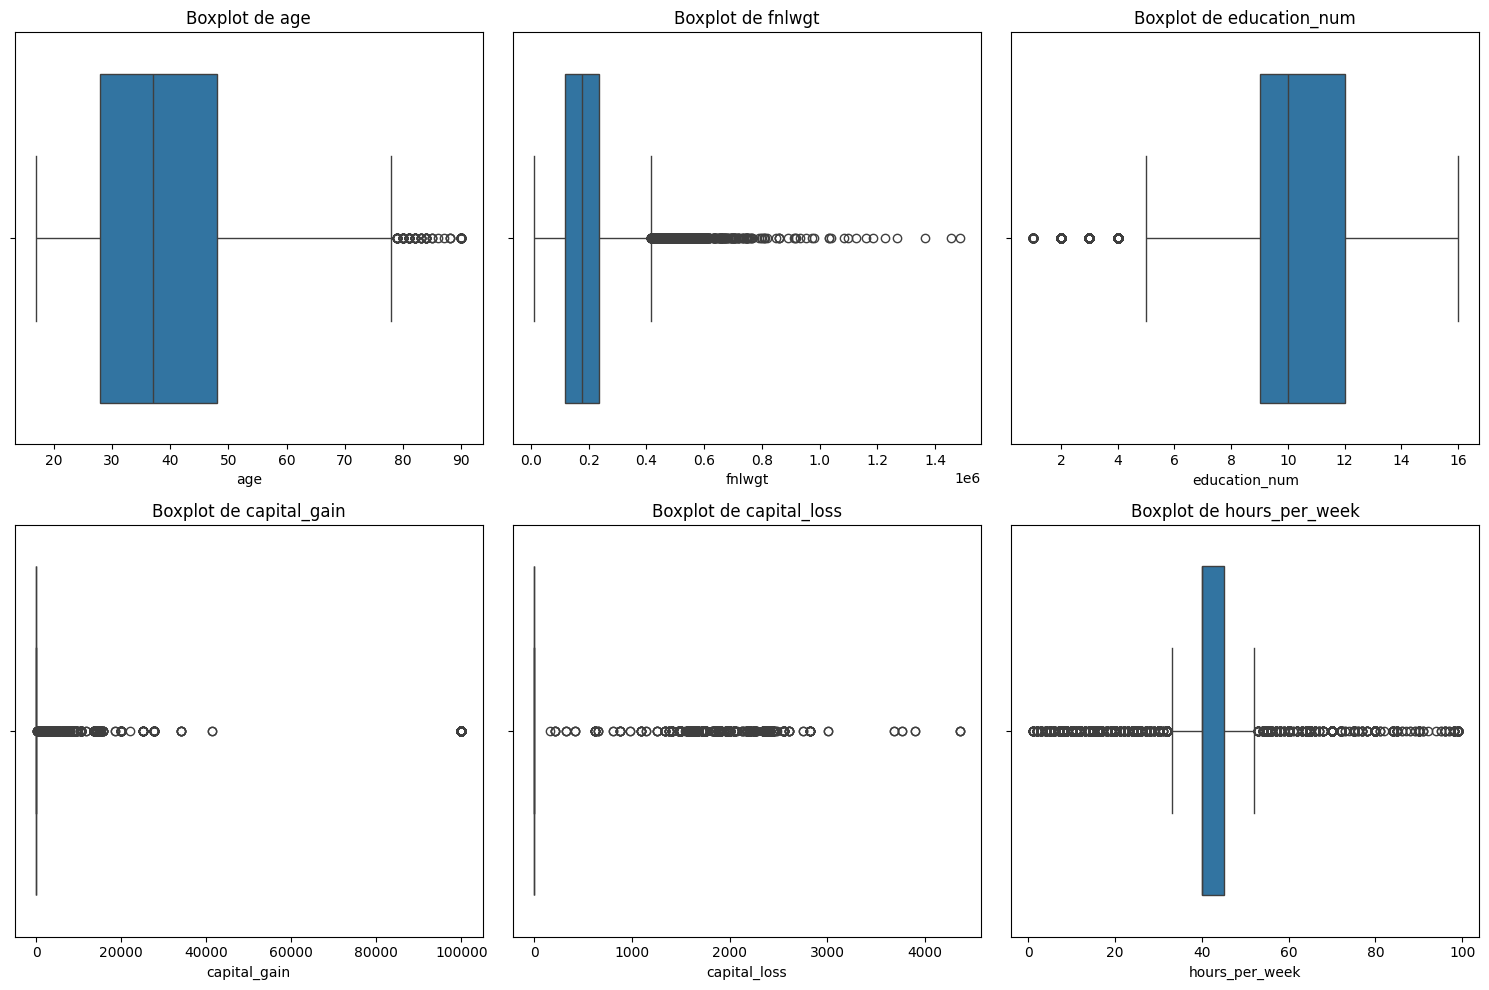

Número de outliers detectados en cada variable:
{'age': 143, 'fnlwgt': 992, 'education_num': 1198, 'capital_gain': 2712, 'capital_loss': 1519, 'hours_per_week': 9008}


In [26]:
## Busco outliers

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]

# Lista de variables numéricas para analizar outliers
numerical_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Crear un gráfico de boxplots para cada variable numérica
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot de {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

# Función para detectar outliers usando el rango intercuartil (IQR)
def detect_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Identificar outliers para cada variable numérica
outliers = {}
for feature in numerical_features:
    lower_bound, upper_bound = detect_outliers_iqr(data, feature)
    outliers[feature] = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].shape[0]

print("Número de outliers detectados en cada variable:")
print(outliers)



In [27]:
# Resumen estadístico de las variables numéricas
summary_stats = data.describe()

# Identificación de outliers usando el método del rango intercuartil (IQR)
def identify_outliers(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

# Variables numéricas para el análisis de outliers
numeric_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Resumen estadístico
print("Resumen estadístico de las variables numéricas:\n")
print(summary_stats)

# Identificación de outliers
outliers = identify_outliers(data, numeric_columns)

print("\nNúmero de outliers detectados en cada variable:")
for col, count in outliers.items():
    print(f'{col}: {count}')


Resumen estadístico de las variables numéricas:

                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours_per_week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  

Número de out

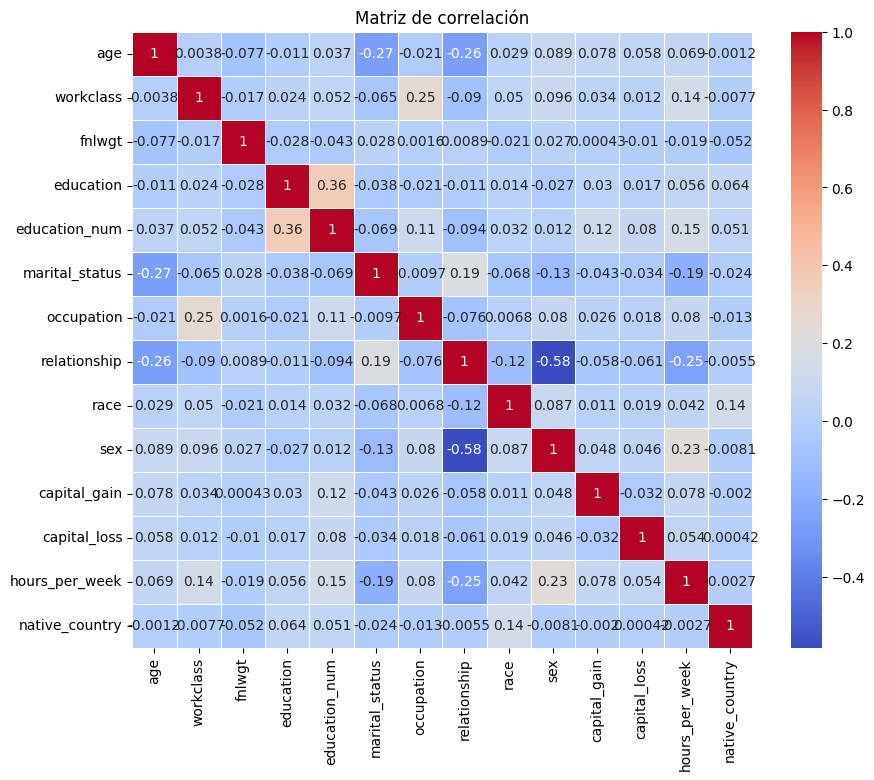

P-values de Chi-cuadrado:
[0.00000000e+000 5.47766026e-012 0.00000000e+000 9.24882165e-067
 0.00000000e+000 2.61759457e-246 9.68421957e-112 0.00000000e+000
 9.06868555e-009 2.80029903e-111 0.00000000e+000 0.00000000e+000
 0.00000000e+000 2.23877386e-004]


In [28]:
# Correlación para variables numéricas y selección Chi-cuadrado para variables categóricas

# Preprocesamiento del dataset

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]

# Cargar el dataset, manejar valores faltantes y eliminar espacios iniciales en columnas
df = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

# Eliminar filas con valores faltantes
df = df.dropna()

# Eliminar espacios en la columna 'income' antes de la conversión binaria
df['income'] = df['income'].str.strip()

# Convertir la columna 'income' a binaria (<=50K -> 0, >50K -> 1)
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Codificar variables categóricas usando LabelEncoder
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

# Separar variables predictoras (X) y la variable objetivo (y)
X = df.drop("income", axis=1)
y = df["income"]

# # Métodos de Filtro

# Correlación para variables numéricas
correlation = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de correlación")
plt.show()

# Selección Chi-cuadrado para variables categóricas
X_categorical = X.select_dtypes(include=['int', 'object']) 
chi_selector = SelectKBest(chi2, k='all')
X_kbest = chi_selector.fit_transform(X_categorical, y)

print("P-values de Chi-cuadrado:")
print(chi_selector.pvalues_)

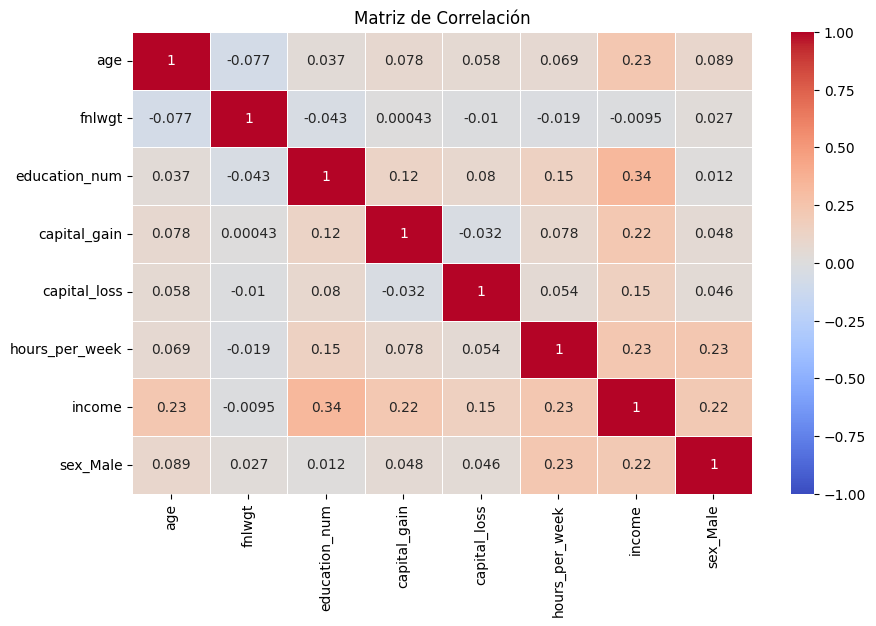

In [29]:
# # matriz de correlación incluyendo income

# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]
data = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Convertir la columna 'income' en una variable binaria (0 y 1)
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Convertir la columna 'sex' en una variable binaria (0 y 1)
data['sex_Male'] = (data['sex'] == 'Male').astype(int)

# Seleccionar solo variables numéricas para la correlación
numeric_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'income', 'sex_Male']

# Crear la matriz de correlación
corr_matrix = data[numeric_columns].corr()

# Graficar el mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()
